# Criteo Uplift v2.1 — Exploratory Analysis

This notebook uses the Parquet dataset produced by the standalone prep script, then performs EDA: schema, missingness, treatment/control balance, outcome rates, and baseline uplift.

Data paths:
- Parquet: `./data/criteo-uplift-v2.1.parquet`

Prerequisite:
- Run: `python src/etl/prepare_dataset.py data/criteo-uplift-v2.1.csv data/criteo-uplift-v2.1.parquet --chunksize 1000000`
- By default, the script auto-downloads from the Criteo page and resolves the direct .csv.gz link: [Criteo Uplift Prediction Dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/)


In [1]:
# Setup
import os
import sys
import gc
import json
import math
from typing import Dict, List, Optional, Tuple

import pandas as pd
import numpy as np

PARQUET_PATH = "../data/criteo-uplift-v2.1.parquet"


In [2]:
# Data availability check

if not os.path.exists(PARQUET_PATH):
    raise FileNotFoundError(
        "Parquet not found. Please run the standalone converter: \n"
        "python src/etl/prepare_dataset.py data/criteo-uplift-v2.1.csv data/criteo-uplift-v2.1.parquet --chunksize 1000000"
    )
else:
    print({"parquet_found": True, "path": PARQUET_PATH})


{'parquet_found': True, 'path': '../data/criteo-uplift-v2.1.parquet'}


In [3]:
# Load Parquet (required)

df = pd.read_parquet(PARQUET_PATH)
print({"loaded": "parquet", "rows": len(df), "cols": len(df.columns)})


{'loaded': 'parquet', 'rows': 12323845, 'cols': 16}


## Dataset fields (from dataset_description.txt)

Expected columns:
- f0..f11: dense float features
- treatment: 1 = treated, 0 = control
- conversion: binary outcome
- visit: binary outcome
- exposure: whether effectively exposed (binary)

Source: [Criteo Uplift Prediction Dataset](https://ailab.criteo.com/criteo-uplift-prediction-dataset/).


In [5]:
# Validate expected columns and basic key figures

expected = set([f"f{i}" for i in range(12)] + ["treatment", "conversion", "visit", "exposure"]) 
missing = sorted(list(expected - set(df.columns)))
extra = sorted(list(set(df.columns) - expected))
print({"missing_expected_columns": missing, "extra_columns_found": extra[:20]})

# Compute key figures
rate_visit = pd.to_numeric(df.get("visit"), errors="coerce").fillna(0).astype(float).mean()
rate_conv = pd.to_numeric(df.get("conversion"), errors="coerce").fillna(0).astype(float).mean()
tr_ratio = pd.to_numeric(df.get("treatment"), errors="coerce").fillna(0).astype(float).mean()

{
    "rows": len(df),
    "avg_visit_rate": round(rate_visit, 5),
    "avg_conversion_rate": round(rate_conv, 5),
    "treatment_ratio": round(tr_ratio, 5),
}


{'missing_expected_columns': [], 'extra_columns_found': []}


{'rows': 12323845,
 'avg_visit_rate': 0.0533,
 'avg_conversion_rate': 0.00331,
 'treatment_ratio': 0.83538}

In [6]:
# Schema and Missingness

print(df.info())

# Memory footprint
mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
print({"memory_mb": round(mem_mb, 2)})

# Missingness summary
nulls = df.isna().sum().sort_values(ascending=False)
nulls_pct = (nulls / len(df) * 100).round(2)
missing_df = pd.DataFrame({"missing": nulls, "missing_pct": nulls_pct})
missing_df.head(20)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12323845 entries, 0 to 12323844
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          Float32
 1   f1          Float32
 2   f2          Float32
 3   f3          Float32
 4   f4          Float32
 5   f5          Float32
 6   f6          Float32
 7   f7          Float32
 8   f8          Float32
 9   f9          Float32
 10  f10         Float32
 11  f11         Float32
 12  treatment   Int8   
 13  conversion  Int8   
 14  visit       Int8   
 15  exposure    Int8   
dtypes: Float32(12), Int8(4)
memory usage: 799.2 MB
None
{'memory_mb': 799.2}


,missing,missing_pct
f0,0,0.0
f1,0,0.0
f2,0,0.0
f3,0,0.0
f4,0,0.0
f5,0,0.0
f6,0,0.0
f7,0,0.0
f8,0,0.0
f9,0,0.0


In [7]:
# Heuristic detection for treatment and outcome columns

from typing import Tuple

def detect_treatment_outcome(columns: List[str]) -> Tuple[Optional[str], Optional[str]]:
    lower = [c.lower() for c in columns]
    treat_aliases = ["treatment", "treat", "exposure", "variant", "w", "trt", "test"]
    outcome_aliases = ["conversion", "converted", "label", "y", "response", "target", "purchase"]

    treatment = None
    outcome = None

    for alias in treat_aliases:
        for c in columns:
            if alias in c.lower():
                treatment = c
                break
        if treatment:
            break

    for alias in outcome_aliases:
        for c in columns:
            if alias in c.lower():
                outcome = c
                break
        if outcome:
            break

    return treatment, outcome

tr_col, y_col = detect_treatment_outcome(df.columns.tolist())
print({"treatment_col": tr_col, "outcome_col": y_col})

# If not found, try common Criteo naming
if tr_col is None:
    for c in df.columns:
        if c.lower() in ["treatment", "treatment_group", "exposed", "exposure", "variant"]:
            tr_col = c
            break
if y_col is None:
    for c in df.columns:
        if c.lower() in ["conversion", "response", "label", "y", "visit", "visit_binary", "conversion_binary"]:
            y_col = c
            break

{"final_treatment_col": tr_col, "final_outcome_col": y_col}


{'treatment_col': 'treatment', 'outcome_col': 'conversion'}


{'final_treatment_col': 'treatment', 'final_outcome_col': 'conversion'}

In [8]:
# Baseline uplift (difference in means) and CI

import math

if tr_col is None or y_col is None:
    raise ValueError("Could not detect treatment/outcome columns automatically. Please set `tr_col` and `y_col`.")

# Ensure numeric/binary
outcome = pd.to_numeric(df[y_col], errors="coerce")
tr = pd.to_numeric(df[tr_col], errors="coerce")

mask = (~outcome.isna()) & (~tr.isna())
outcome = outcome[mask]
tr = tr[mask]

# Binariaze if needed (assume >0 means positive)
if sorted(outcome.unique()) not in ([0,1], [0.0,1.0]):
    outcome = (outcome > 0).astype(int)

tr = (tr > 0).astype(int)

p_treat = outcome[tr == 1].mean()
p_ctrl = outcome[tr == 0].mean()
uplift = p_treat - p_ctrl

# Wald CI for difference in proportions
n_t = (tr == 1).sum()
n_c = (tr == 0).sum()
se = math.sqrt(p_treat*(1-p_treat)/n_t + p_ctrl*(1-p_ctrl)/n_c)
z = 1.96
ci_low = uplift - z * se
ci_high = uplift + z * se

{
    "n_treat": int(n_t),
    "n_control": int(n_c),
    "p_treat": round(p_treat, 6),
    "p_control": round(p_ctrl, 6),
    "uplift": round(uplift, 6),
    "ci95": (round(ci_low, 6), round(ci_high, 6))
}


{'n_treat': 10295062,
 'n_control': 2028783,
 'p_treat': 0.003566,
 'p_control': 0.002003,
 'uplift': 0.001563,
 'ci95': (0.001492, 0.001635)}

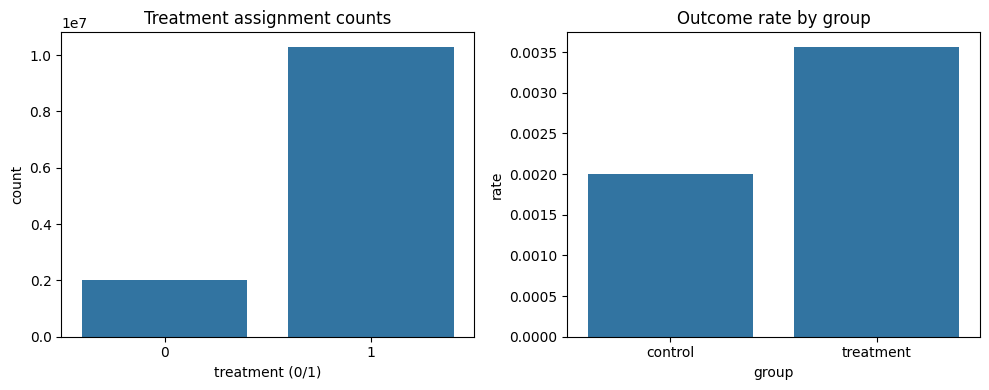

In [9]:
# Simple plots: treatment balance and outcome rates
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(10,4))

sns.countplot(x=tr, ax=axes[0])
axes[0].set_title("Treatment assignment counts")
axes[0].set_xlabel("treatment (0/1)")

rates = pd.DataFrame({
    "group": ["control", "treatment"],
    "rate": [p_ctrl, p_treat]
})
sns.barplot(data=rates, x="group", y="rate", ax=axes[1])
axes[1].set_title("Outcome rate by group")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

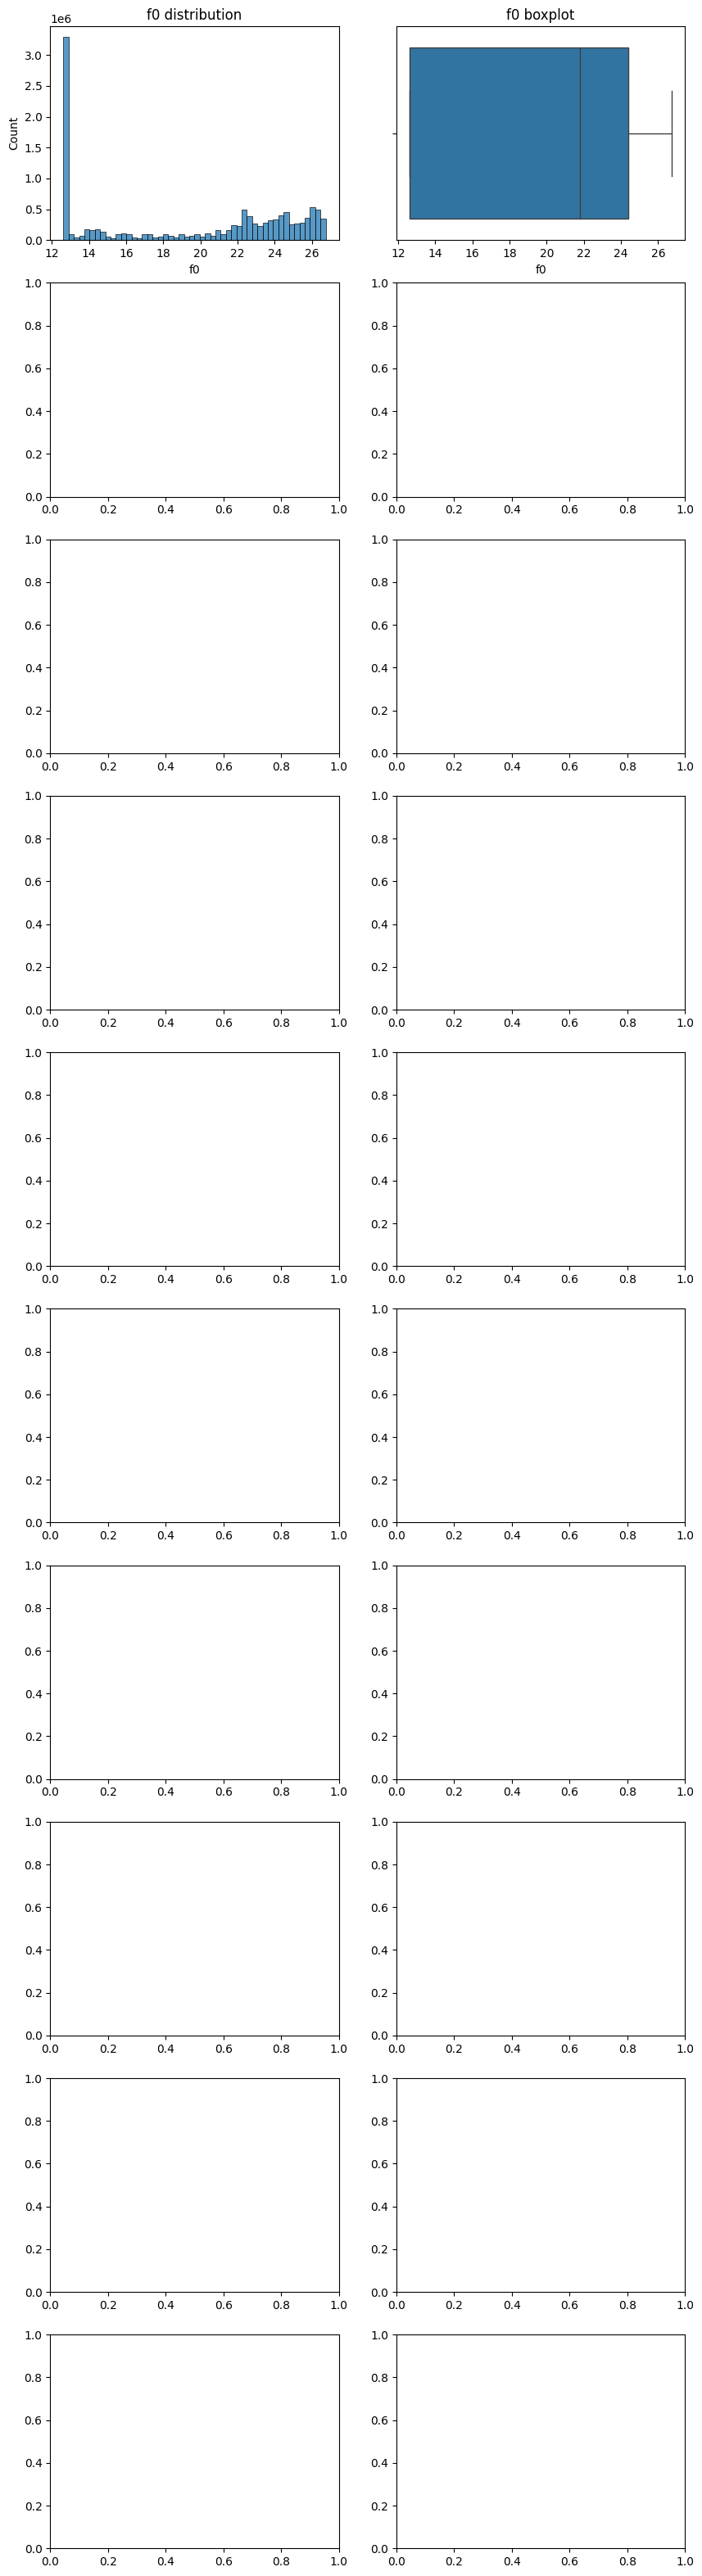

In [10]:
# Optional: feature distribution snapshots (top-K columns)

K = 10
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in {tr_col, y_col}][:K]
cat_cols = [c for c in df.select_dtypes(exclude=[np.number]).columns][:K]

fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 4*len(num_cols))) if num_cols else (None, None)
if num_cols:
    for i, c in enumerate(num_cols):
        sns.histplot(df[c], bins=50, ax=axes[i,0])
        axes[i,0].set_title(f"{c} distribution")
        sns.boxplot(x=df[c], ax=axes[i,1])
        axes[i,1].set_title(f"{c} boxplot")
    plt.tight_layout()
    plt.show()

if cat_cols:
    for c in cat_cols:
        plt.figure(figsize=(8,3))
        vc = df[c].astype(str).value_counts().head(20)
        sns.barplot(x=vc.values, y=vc.index)
        plt.title(f"Top categories for {c}")
        plt.tight_layout()
        plt.show()
